# Samples and periods
***

***Author:** Chus Casado Rodríguez*<br>
***Date:** 16-05-2024*<br>

**Introduction**

In this notebook a sample of reservoirs and its corresponding time series are split into a training, validating and testing sample and periods. The size of the three samples is configured with the attributes `TRAIN_SIZE` and `VAL_SIZE` (the testing size, if any, is the remaining of 1 minus the train and validation size). At the moment, to include longer time series in the training/testing process, the complete time series of a specific reservoir is used for either training, validating or testing, depending on the sample to which that specific reservoir belongs to. That means that there is not temporal validation. To change this behaviour, modifications must be made on the use of the `split_periods` function.

The notebook allows to select reservoir with a specific use and single-purpose using the configuration attributes `USE` and `SINGLE_USE`, respectively.

The attribute `TARGET` is used to select the configuration files specific to the target variable.

In [4]:
import sys
sys.path.append('..')
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.auto import tqdm
import pickle
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from neuralhydrology.utils.config import Config

from plots import plot_timeseries
from model_utils import split_samples, split_periods

## Configuración

In [5]:
TRAIN_SIZE = .7
VAL_SIZE = .3
USE = None #'supply'
SINGLE_USE = False #True
TARGET = 'outflow'

In [7]:
# cargar archivo de configuración
if USE:
    exp_dir = Path(f'./{USE}/{TARGET}/')
else:
    exp_dir = Path(f'./all/{TARGET}/')   
config_file = list(exp_dir.glob('config_*.yml'))[0]
print(f'Reading configuration file:\n{config_file}')
cfg = Config(config_file)

if len(set(TARGET.split('_')).difference(cfg.target_variables)) > 0:
    print(f'ERROR. The targets do not match with the experiment folder:\n{exp_dir}\n{cfg.target_variables}')

Reading configuration file:
all/outflow/config_O_lstm256_fc00_do04.yml


## Load data

### Attributes

In [8]:
# load attribute table
attrs = pd.read_csv(cfg.data_dir / 'attributes' / 'attributes_combined.csv', index_col='reservoir_id')
attrs = attrs[attrs.columns.intersection(cfg.static_attributes + ['RES_NAME'])]
attrs.dropna(axis=0, how='any', inplace=True)
print('Reservoirs in the original attribute table:\t{0}'.format(attrs.shape[0]))

# load reservoir use table
use = pd.read_csv(cfg.data_dir / 'attributes' / 'attributes_use.csv', index_col='reservoir_id')
use = use[use.columns.intersection(cfg.static_attributes)]
use.dropna(axis=0, how='any', inplace=True)
print('Reservoirs in the original use table:\t\t{0}'.format(use.shape[0]))

if attrs.shape[0] != use.shape[0]:
    ids = attrs.index.intersection(use.index)
    attrs = attrs.loc[ids]
    use = use.loc[ids]
    
# select single-use, hydropower reservoirs
if SINGLE_USE:
    mask1 = use.sum(axis=1) == 1
else:
    mask1 = pd.Series(True, index=use.index)
if USE:
    mask2 = use[USE] == 1
else:
    mask2 = pd.Series(True, index=use.index)
attrs_sel = attrs.loc[mask1 & mask2]
print('Selected reservoirs:\t\t\t\t{0}'.format( attrs_sel.shape[0]))

Reservoirs in the original attribute table:	289
Reservoirs in the original use table:		290
Selected reservoirs:				289


### Time series

In [9]:
# variables required by the model
ts_vars = cfg.target_variables + cfg.dynamic_inputs

# load timeseries
path_ts = cfg.data_dir / 'time_series'
timeseries = {}
for ID in tqdm(attrs_sel.index):
    file = path_ts / f'{ID}.nc'
    if file.is_file():
        try:
            timeseries[ID] = xr.open_dataset(file).to_pandas()[ts_vars]
        except Exception as e:
            print(f'{ID}: {e}')
            attrs_sel.drop(ID, axis=0, inplace=True)
    else:
        print(f'{file} was not found')
        
print('Reservoirs with all dynamic variables:\t\t{0}'.format(len(timeseries)))

  0%|          | 0/289 [00:00<?, ?it/s]

1062: "['outflow'] not in index"
1066: "['outflow'] not in index"
1075: "['outflow'] not in index"
1078: "['outflow'] not in index"
1146: "['outflow'] not in index"
1255: "['outflow'] not in index"
1272: "['outflow'] not in index"
1450: "['outflow'] not in index"
165: "['outflow'] not in index"
1964: "['outflow'] not in index"
2044: "['outflow'] not in index"
2109: "['outflow'] not in index"
2180: "['outflow'] not in index"
234: "['outflow'] not in index"
2511: "['outflow'] not in index"
2539: "['outflow'] not in index"
257: "['outflow'] not in index"
328: "['outflow'] not in index"
342: "['outflow'] not in index"
3499: "['outflow'] not in index"
351: "['outflow'] not in index"
369: "['outflow'] not in index"
556: "['outflow'] not in index"
616: "['outflow'] not in index"
659: "['outflow'] not in index"
725: "['outflow'] not in index"
793: "['outflow'] not in index"
971: "['outflow'] not in index"
Reservoirs with all dynamic variables:		261


## Split samples and periods

### Samples

In [10]:
# divide sample in calibration, validation and test subsets
path = exp_dir / cfg.train_basin_file.parent
path.mkdir(exist_ok=True)
samples = split_samples(attrs_sel.index.tolist(), cal=TRAIN_SIZE, val=VAL_SIZE, seed=0)#, path=path)
# export
if path is not None:
    for key, ls in samples.items():
        with open(path / f'sample_{key}.txt', 'w') as file:
            file.writelines(f"{id}\n" for id in ls)

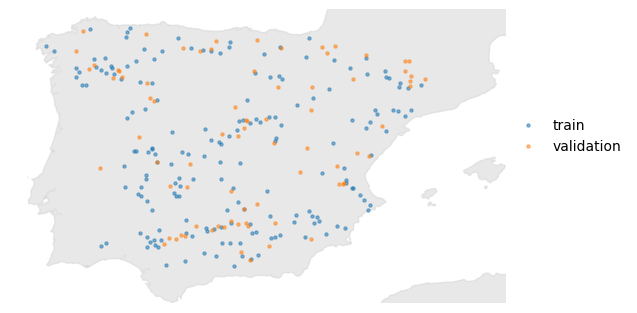

In [11]:
# plot reservoir locations
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
for sample, ids in samples.items():
    ax.scatter(attrs_sel.loc[ids, 'LON'], attrs_sel.loc[ids, 'LAT'], s=5, alpha=.5, label=sample)
ax.set_aspect('equal')
ax.set_extent([-10, 3.5, 36, 44])
fig.legend(frameon=False, bbox_to_anchor=[1., .4, .1, .2])
ax.axis('off');

plt.savefig(path / 'map_reservoirs.jpg', dpi=300, bbox_inches='tight');

### Periods 

In [12]:
# hard-code start of time series for reservoirs with errors
correct_start = {84: np.datetime64('1995-10-01', 'ns'),
                 2111: np.datetime64('1995-10-01', 'ns'),
                 2431: np.datetime64('1995-10-01', 'ns'),
                 2483: np.datetime64('1995-10-01', 'ns'),
                 593: np.datetime64('1995-10-01', 'ns')}

# define train, validation and test periods
periods = {}
for ID, df in timeseries.items():
    if ID in samples['train']:
        period = 'train'
        da = split_periods(df, cal=1, val=0)
    elif ID in samples['validation']:
        period = 'validation'
        da = split_periods(df, cal=0, val=1)
    if ID in correct_start:
        da.loc[{'date': 'start', 'period': period}] = correct_start[ID]
    periods[ID] = da
periods_da = xr.concat([da.assign_coords(id=str(ID)) for ID, da in periods.items()], dim='id')

# make sure there's 1 year of data before the start date
cutoff_date = np.datetime64('1992-01-02', 'ns')
periods_da = periods_da.where(periods_da >= cutoff_date, other=cutoff_date)
del periods

# reorganize periods as a dictionary
periods_dct = {}
for period in periods_da.period.data:
    periods_dct[period] = {}
    for ID in periods_da.id.data:
        periods_dct[period][ID] = {}
        for date in periods_da.date.data:
            periods_dct[period][ID][f'{date}_dates'] = [pd.Timestamp(periods_da.sel(period=period, id=ID, date=date).to_numpy().item())]

# export as a Pickle
for period, dct in periods_dct.items():
    with open(path / f'periods_{period}.pkl', 'wb') as file:
        pickle.dump(dct, file)

### Plot

In [16]:
# plot timeserie
path_plots = path_ts / 'plots'
path_plots.mkdir(parents=True, exist_ok=True)
for ID, df in tqdm(timeseries.items()):
    save = path_plots / f'{ID}.jpg'
    if save.is_file():
        continue
        
    # find start and end dates
    for p in list(samples):
        if ID in samples[p]:
            period = p
    start = periods_dct[period][str(ID)]['start_dates'][0]
    end = periods_dct[period][str(ID)]['end_dates'][0]
    
    try:
        title = '{0} - {1}\nDOR = {2:.3f}  DOD = {3:.3f} m'.format(ID, *attrs.loc[ID, ['RES_NAME', 'DOR', 'DOD_M']])
        if 'outflow' in df.columns:
            outflow = 'outflow'
        else:
            outflow = None
        plot_timeseries(df.loc[start:end], 'volume', 'inflow_efas5', outflow, ylabel='fraction filled (-)', title=title,
                        save=path_plots / f'{ID}.jpg')
    except Exception as e:
        print(f'ERROR: An error occurred while plotting timeseries for ID {ID}:\n{e}')

  0%|          | 0/261 [00:00<?, ?it/s]